In [2]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, accuracy_score

# Set the seed for reproducibility
torch.manual_seed(10)
np.random.seed(10)
random.seed(10)

# Define transformation with increased augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),  # Increased rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard transformation for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets with appropriate transformations
original_train_ds = datasets.ImageFolder(root="train", transform=train_transform)
test_ds = datasets.ImageFolder(root="test", transform=test_transform)

# Calculate dataset sizes for splitting
test_size = len(test_ds) // 5
train_size = len(original_train_ds) - test_size
train_ds, _ = random_split(original_train_ds, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=4)
classes = original_train_ds.classes

# Initialize the ResNet model with modified classifier
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Increased dropout
    nn.Linear(512, len(classes))
)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001, weight_decay=1e-4)  # Added L2 regularization

# Track training and testing accuracy
train_accuracies, test_accuracies = [], []

# Training loop with early stopping
epochs = 5
best_test_loss = float('inf')
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}/{epochs}")
    start_time = time.time()

    train_loss, train_correct, test_loss, test_correct = 0, 0, 0, 0
    resnet.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data).item()

    train_acc = (train_correct / len(train_loader.dataset)) * 100
    train_accuracies.append(train_acc)

    resnet.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels.data).item()

    test_acc = (test_correct / len(test_loader.dataset)) * 100
    test_accuracies.append(test_acc)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
    else:
        print("Stopping early due to increase in test loss.")
        break

    print(f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    print(f'Epoch Duration: {time.time() - start_time:.0f} seconds')


Start of epoch 1/5
Train Acc: 43.25%, Test Acc: 81.33%
Epoch Duration: 341 seconds

Start of epoch 2/5
Train Acc: 67.43%, Test Acc: 87.33%
Epoch Duration: 291 seconds

Start of epoch 3/5
Train Acc: 70.86%, Test Acc: 88.00%
Epoch Duration: 278 seconds

Start of epoch 4/5
Train Acc: 73.77%, Test Acc: 89.33%
Epoch Duration: 279 seconds

Start of epoch 5/5
Train Acc: 75.06%, Test Acc: 90.00%
Epoch Duration: 278 seconds


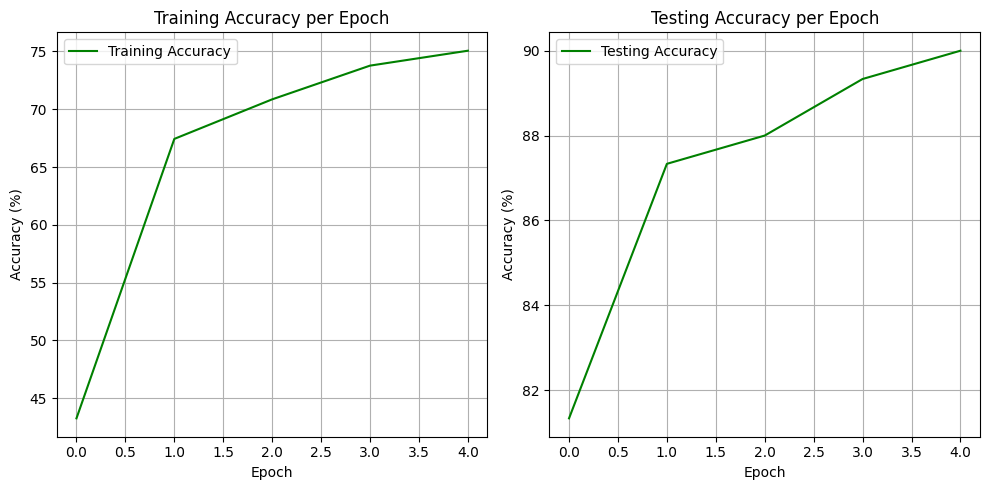

In [3]:
# Separate plots for training and testing accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy', color='Green')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Testing Accuracy', color='Green')
plt.title('Testing Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# Evaluation
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

report = classification_report(y_true, y_pred, labels=range(len(classes)), target_names=classes)
accuracy = accuracy_score(y_true, y_pred)
print(report)
print(f'Overall accuracy: {accuracy * 100:.2f}%')

                   precision    recall  f1-score   support

         baseball       1.00      1.00      1.00         5
       basketball       1.00      0.60      0.75         5
       beachballs       1.00      1.00      1.00         5
    billiard ball       1.00      1.00      1.00         5
     bowling ball       0.56      1.00      0.71         5
            brass       1.00      0.20      0.33         5
      buckeyballs       1.00      1.00      1.00         5
      cannon ball       0.83      1.00      0.91         5
    chrochet ball       1.00      0.80      0.89         5
     cricket ball       1.00      1.00      1.00         5
     crystal ball       0.83      1.00      0.91         5
         eyeballs       1.00      1.00      1.00         5
         football       0.80      0.80      0.80         5
        golf ball       1.00      1.00      1.00         5
           marble       1.00      0.80      0.89         5
        meat ball       1.00      1.00      1.00       